In [165]:
# PYTHON 
import os 
import pandas as pd
import numpy as np
import regex as re
from datetime import datetime

# SPLINK
import splink.duckdb.comparison_library as cl
import splink.duckdb.comparison_template_library as ctl
import splink.duckdb.comparison_level_library as cll
from splink.duckdb.linker import DuckDBLinker
from splink.duckdb.blocking_rule_library import block_on
from splink.datasets import splink_datasets

# RENDER CHARTS
import altair as alt
#alt.renderers.enable('html')
#alt.renderers.enable('altair_viewer')
alt.renderers.enable('mimetype')

import logging
import warnings

In [2]:
doc_site_sim1 = pd.read_csv("doc_site_sim1.csv").astype("string")
doc_site_sim1_a = doc_site_sim1[[ "office_id","doc_site_id","doc_id","firstname","lastname","pcode","phonenum"] ].assign(
                                                        unique_id=doc_site_sim1["doc_site_id"]+"_a")
doc_site_sim1_b = doc_site_sim1[[ "office_id","doc_site_id","doc_id","firstname_noised","lastname_noised","pcode_noised","phonenum_noised"]].rename(
                            columns={"firstname_noised":"firstname",
                                     "lastname_noised":"lastname",
                                     "pcode_noised":"pcode",
                                     "phonenum_noised":"phonenum"}).assign(
                                                        unique_id=doc_site_sim1["doc_site_id"]+"_b")

In [3]:
first_name_comparison = {
    'output_column_name': 'firstname',
    'comparison_levels': [
        
        {
            'sql_condition': "firstname_l IS NULL OR firstname_r IS NULL",
            'label_for_charts': 'Null',
            'is_null_level': True
        },
        {
            'sql_condition': "firstname_l = firstname_r",
            'label_for_charts': 'Exact match on First Name', 
            #'m_probability': 0.70
          #  "tf_adjustment_column": "first_name",
          #  "tf_adjustment_weight": 1.0,
          #  "tf_minimum_u_value": 0.0005
        },
        {
            'sql_condition': '(length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1))',
            'label_for_charts': 'first initial match', 
            #'m_probability': 0.15
           # "tf_adjustment_column": "first_name",
           # "tf_adjustment_weight": 1.0,
           # "tf_minimum_u_value": 0.0005

        },

        {
            'sql_condition': "jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9",
            'label_for_charts': 'Jaro_winkler >= 0.9 - name spelling discrepancies', 
            #'m_probability': 0.15
            #"tf_adjustment_column": "first_name",
            #"tf_adjustment_weight": 1.0,
            #"tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': "jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80", ## First Name Descrepency
            'label_for_charts': 'jaro_winkler >= 0.80 - name spelling discrepancies',
            #'m_probability': 0.05
            #"tf_adjustment_column": "first_name",
            #"tf_adjustment_weight": 1.0,
            #"tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': "damerau_levenshtein(firstname_l, firstname_r) <= 1",
            'label_for_charts': 'Damerau_levenshtein = 1 - one typos',
            #"tf_adjustment_column": "first_name",
            #"tf_adjustment_weight": 1.0,
            #"tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': "damerau_levenshtein(firstname_l, firstname_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 - two typos',
           # "tf_adjustment_column": "first_name",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons',
            #'m_probability': 0.03 #### 
        }],
    
    'comparison_description': 'Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else'
}

last_name_comparison = {
    'output_column_name': 'lastname',
    'comparison_levels': [
        
        {
            'sql_condition': "lastname_l IS NULL OR lastname_r IS NULL",
            'label_for_charts': 'Null',
            'is_null_level': True
        },
        {
            'sql_condition': "lastname_l = lastname_r",
            'label_for_charts': 'Exact match on Last Name', 
            #'m_probability': 0.70
            #"tf_adjustment_column": "surname",
            #"tf_adjustment_weight": 1.0,
            #"tf_minimum_u_value": 0.0005
        },

        {
            'sql_condition': "jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9",
            'label_for_charts': 'Jaro_winkler >= 0.9 - front of string discrepdendies', 
            #'m_probability': 0.15
           # "tf_adjustment_column": "surname",
            "tf_adjustment_weight": 1.0,
            "tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': "jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8", ## First Name Descrepency
            'label_for_charts': 'jaro_winkler >= 0.8 - name spelling discrepancies throughout str',
            # 'm_probability': 0.05
           # "tf_adjustment_column": "surname",
           # "tf_adjustment_weight": 1.0,
           # "tf_minimum_u_value": 0.0005

        },
       # {
       #     'sql_condition': "damerau_levenshtein(surname_l, surname_r) = 1",
       #     'label_for_charts': 'Damerau_levenshtein = 1 for typos',
       #     "tf_adjustment_column": "surname",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005

       # },
        {
            'sql_condition': "damerau_levenshtein(lastname_l, lastname_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 for typos',
           # "tf_adjustment_column": "surname",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons',
            #'m_probability': 0.03 #### 
        }],
    
    'comparison_description': 'Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else'
}

pcode_comparison = {
    'output_column_name': 'pcode',
    'comparison_levels': [
        
        {
            'sql_condition': " pcode_l is NULL OR pcode_r is NULL ",
            # 'sql_condition': 'Postal_Code_Array_l IS NULL OR Postal_Code_Array_r IS NULL',  
            'label_for_charts': 'Null',
            'is_null_level': True
        },

       {
            'sql_condition': "pcode_l=pcode_r",
            'label_for_charts': 'Exact match',
       #     "tf_adjustment_column": "surname",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005

        },
       {
            'sql_condition': "damerau_levenshtein(pcode_l, pcode_r) = 1",
            'label_for_charts': 'Damerau_levenshtein = 1 for typos',
       #     "tf_adjustment_column": "surname",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': "damerau_levenshtein(pcode_l, pcode_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 for typos',
           # "tf_adjustment_column": "surname",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005

        },
        
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons'
        }],

    'comparison_description': 'Null vs. exact vs D-L 1 vs D-L 2  vs. anything else'
}


phonenum_comparison = {
    'output_column_name': 'phonenum',
    'comparison_levels': [
        
        {
            'sql_condition': " phonenum_l is NULL OR phonenum_r is NULL ",
            # 'sql_condition': 'Postal_Code_Array_l IS NULL OR Postal_Code_Array_r IS NULL',  
            'label_for_charts': 'Null',
            'is_null_level': True
        },

       {
            'sql_condition': "phonenum_l=phonenum_r",
            'label_for_charts': 'Exact match',
       #     "tf_adjustment_column": "surname",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005

        },
       {
            'sql_condition': "damerau_levenshtein(phonenum_l, phonenum_r) = 1",
            'label_for_charts': 'Damerau_levenshtein = 1 for typos',
       #     "tf_adjustment_column": "surname",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005

        },
        {
            'sql_condition': "damerau_levenshtein(phonenum_l, phonenum_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 for typos',
           # "tf_adjustment_column": "surname",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005

        },
        
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons'
        }],

    'comparison_description': 'Null vs. exact vs D-L 1 vs D-L 2  vs. anything else'
}


In [4]:
settings = {
    "link_type": "link_only",
    
    "blocking_rules_to_generate_predictions": [

#        "len(array_intersect(l.postcode_fake, r.postcode_fake)) = 1",
        "right(l.pcode,2)=right(r.pcode,2)",
        "substr(l.phonenum,1,2)=substr(r.phonenum,1,2)", 
        #"size(array_intersect(l.City_Array, r.City_Array)) = 1 and substr(l.Last_Name, 1, 1) = substr(r.Last_Name, 1, 1)",
        "l.firstname = r.firstname", 
        "l.lastname = r.lastname",
        "substr(l.firstname, 1, 1) = substr(r.firstname, 1, 1) and substr(l.lastname, 1, 1) = substr(r.lastname, 1, 1)"
    ],

    

    "comparisons": [
        
        first_name_comparison,

        last_name_comparison, 

        pcode_comparison,
        
        phonenum_comparison#,

       # ctl.date_comparison("dob",cast_strings_to_date=True)
    
    ],
    
    "retain_matching_columns": True, 


    "retain_intermediate_calculation_columns": True,

    # "em_convergence": 0.01,

    "max_iterations": 50, ### fro review 

    "unique_id_column_name":'unique_id',
    
    "sql_dialect":'duckdb'}


In [5]:
linker = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 

In [6]:
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs


In [7]:
## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 

----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [8]:
blocking_rules = [ 
            "l.firstname = r.firstname", 
        "l.lastname = r.lastname",
        "substr(l.firstname, 1, 1) = substr(r.firstname, 1, 1) and substr(l.lastname, 1, 1) = substr(r.lastname, 1, 1)",
    "right(l.pcode,2)=right(r.pcode,2)",
        "substr(l.phonenum,1,2)=substr(r.phonenum,1,2)",
        #"size(array_intersect(l.City_Array, r.City_Array)) = 1 and substr(l.Last_Name, 1, 1) = substr(r.Last_Name, 1, 1)",
                 ]

for i in blocking_rules: 

    count = linker.count_num_comparisons_from_blocking_rule(i)

    print(f"'{i}' ---> {count:,.0f} comparisons")

linker.cumulative_num_comparisons_from_blocking_rules_chart(blocking_rules)

'l.firstname = r.firstname' ---> 162,563 comparisons
'l.lastname = r.lastname' ---> 189,545 comparisons
'substr(l.firstname, 1, 1) = substr(r.firstname, 1, 1) and substr(l.lastname, 1, 1) = substr(r.lastname, 1, 1)' ---> 256,156 comparisons
'right(l.pcode,2)=right(r.pcode,2)' ---> 1,109,575 comparisons
'substr(l.phonenum,1,2)=substr(r.phonenum,1,2)' ---> 783,694 comparisons


<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [9]:
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker.estimate_parameters_using_expectation_maximisation(blocking_rules[i])


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,CASE WHEN  pcode_l is NULL OR pcode_r is NULL  THEN -1 WHEN pcode_l=pcode_r THEN 3 WHEN damerau_levenshtein(pcode_l, pcode_r) = 1 THEN 2 WHEN damerau_levenshtein(pcode_l, pcode_r) = 2 THEN 1 ELSE 0 END as gamma_pcode,CASE WHEN  phonenum_l is NULL OR phonenum_r is NULL  THEN -1 WHEN phonenum_l=phonenum_r THEN 3 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 1 THEN 2 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 2 THEN 1 ELSE 0 END as gamma_phonenum,match_key 
    from __splink__df_blocked
    


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Iteration 1: Largest change in params was -0.284 in the m_probability of lastname, level `Exact match on Last Name`


Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_lastname', 'gamma_pcode', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 2: Largest change in params was -0.0191 in the m_probability of pcode, level `Exact match`
Iteration 3: Largest change in params was 0.00945 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.00586 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.00423 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.00329 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 0.00267 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was 0.00223 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.00192 in the m_probability of phonenum, level `All other comparisons`
Iteration 10: Largest change in params was 0.00169 in the m_probability of phonenum, level `All other

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4285214f0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428521e80>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428521cd0>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Iteration 1: Largest change in params was -0.235 in the m_probability of firstname, level `Exact match on First Name`


Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_pcode', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 2: Largest change in params was -0.0406 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was 0.0138 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.0114 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.00948 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.00768 in the m_probability of pcode, level `All other comparisons`
Iteration 7: Largest change in params was 0.00605 in the m_probability of pcode, level `All other comparisons`
Iteration 8: Largest change in params was 0.00464 in the m_probability of pcode, level `All other comparisons`
Iteration 9: Largest change in params was 0.00349 in the m_probability of pcode, level `All other comparisons`
Iteration 10: Largest change in params was 0.00259 in the m_probability of pcode, level `All othe

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b42559f550>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42559b0a0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42559b190>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN  pcode_l is NULL OR pcode_r is NULL  THEN -1 WHEN pcode_l=pcode_r THEN 3 WHEN damerau_levenshtein(pcode_l, pcode_r) = 1 THEN 2 WHEN damerau_levenshtein(pcode_l, pcode_r) = 2 THEN 1 ELSE 0 END as gamma_pcode,CASE WHEN  phonenum_l is NULL OR phonenum_r is NULL  THEN -1 WHEN phonenum_l=phonenum_r THEN 3 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 1 THEN 2 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 2 THEN 1 ELSE 0 END as gamma_phonenum,match_key 
    from __splink__df_blocked
    


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Iteration 1: Largest change in params was 0.575 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was 0.0163 in the m_probability of pcode, level `All other comparisons`


Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_pcode', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 3: Largest change in params was -0.0112 in probability_two_random_records_match
Iteration 4: Largest change in params was -0.0111 in probability_two_random_records_match
Iteration 5: Largest change in params was -0.0112 in probability_two_random_records_match
Iteration 6: Largest change in params was -0.0114 in probability_two_random_records_match
Iteration 7: Largest change in params was -0.0117 in probability_two_random_records_match
Iteration 8: Largest change in params was -0.0119 in probability_two_random_records_match
Iteration 9: Largest change in params was -0.0122 in probability_two_random_records_match
Iteration 10: Largest change in params was -0.0125 in probability_two_random_records_match
Iteration 11: Largest change in params was -0.0127 in probability_two_random_records_match
Iteration 12: Largest change in params was -0.013 in probability_two_random_records_match
Iteration 13: Largest change in params was -0.0133 in probability_two_random_records_match
Iterati

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4255886d0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42880bf40>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastn

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_lastname', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.339 in the m_probability of lastname, level `All other comparisons`
Iteration 2: Largest change in params was 0.482 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was 0.0876 in the m_probability of firstname, level `All other comparisons`
Iteration 4: Largest change in params was 0.00466 in the m_probability of firstname, level `All other comparisons`
Iteration 5: Largest change in params was 0.00107 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.00112 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 0.00115 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was 0.00119 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.00123 in the m_probability of phonenum, level 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b4288b3f10>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4288b3880>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4288b3b20>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN da

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_lastname', 'gamma_pcode', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.383 in the m_probability of lastname, level `All other comparisons`
Iteration 2: Largest change in params was 0.0395 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was 0.0133 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 4: Largest change in params was 0.0114 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 5: Largest change in params was 0.00816 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 6: Largest change in params was 0.00528 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 7: Largest change in params was 0.00319 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 8: Largest change in params was -0.0019 in the m_probability of pcode, level `Exact match`
Iteration 9: Largest change in params was -0.00116 in the m_

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b4288c5fd0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b428629f40>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42864ff40>]


convergence problems for blocking on phonenum & pcode

In [10]:
linker.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Very bad all others for firstname and lastname!

In [11]:
linker.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [12]:
linker.parameter_estimate_comparisons_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Clear block dependence in model fitting ... only blocking on first and last give reasonable results. 
Try adding semi-supervised rule - gamma=0 for first and last means not a match

In [13]:
# setup as above
linker2 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker2.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker2.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [14]:
# estimate with a semi-supervised rule
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker2.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1}],
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"pcode_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on c

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4285760d0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428576850>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428576400>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Largest

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b428576dc0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4285394c0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42cad50d0>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.611 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.0417 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was 0.0513 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.0597 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0657 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was 0.0648 in the m_probability of firstname, level `Exact match on First Name`
Iteration 7: Largest change in params was 0.0541 in the m_probability of firstname, level `Exact match on First Name`
Iteration 8: Largest change in params was -0.0372 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was -0.0606 in the m_probability of lastname, level

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428930940>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428930070>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.293 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was -0.155 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0411 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00994 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.00238 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000558 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -0.000129 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was -2.94e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 8 iterations

Your model is fully trained. All comparisons have a

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b428a1c310>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b428a1c3d0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428a200a0>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.25 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was 0.072 in the m_probability of pcode, level `Exact match`
Iteration 3: Largest change in params was 0.0121 in the m_probability of pcode, level `Exact match`
Iteration 4: Largest change in params was 0.0021 in the m_probability of pcode, level `Exact match`
Iteration 5: Largest change in params was 0.000458 in the m_probability of pcode, level `Exact match`
Iteration 6: Largest change in params was -0.000135 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -4.98e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b428a20ca0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b428a7f8e0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428a6f8b0>]


No convergence problems AT ALL!

In [15]:
linker2.parameter_estimate_comparisons_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


* all other estimates for first and last name were still too high for those blocks when match_probability was set to 0.01 (50%), but they are much but much better now that match_probability is set to 0. though they are still a bit too high. In both cases they were much better than without semi-sopervised (was 90%)
* all other estimates for phonenum and pcode are now not so great for the pcode and phonenum blocks -- too low.
* in general semi-supervised rule tweaking may need to be different depending on block.
                                                                                

In [16]:
linker.parameter_estimate_comparisons_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [17]:
linker2.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [18]:
linker.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [19]:
linker2.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [20]:
linker.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


* Has much better negative match weights for names
* negative match weights for pcode and phonenumber and very reduced in size, which is what we want; though perhaps not enough due to pcode and phonenum blocks
*  postive match weights for pcode and phone number are also a bit less
  
To do:

* compare predictions/AUC etc.
* see if other semi-supervised steps can improve model
* see if TF can improve model

In [21]:
predictions_df = linker.predict().as_pandas_dataframe()
predictions2_df= linker2.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [22]:
predictions_df = predictions_df.merge( doc_site_sim1_a[ ["unique_id","doc_id","doc_site_id","office_id"] ].rename(
                                            columns = {"unique_id":"unique_id_l",
                                                       "doc_id":"doc_id_l",
                                                       "doc_site_id":"doc_site_id_l",
                                                       "office_id": "office_id_l"}),
                                      on = "unique_id_l",
                                      how="outer").merge(
                                            doc_site_sim1_b[ ["unique_id","doc_id","doc_site_id","office_id"]].rename(
                                            columns = {"unique_id":"unique_id_r",
                                                       "doc_id":"doc_id_r",
                                                       "doc_site_id":"doc_site_id_r",
                                                       "office_id": "office_id_r"}),
                                      on = "unique_id_r",
                                      how="outer"
                                        )

In [23]:
predictions_df = predictions_df.merge( predictions2_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight2",
                                                         "match_probability":"match_probability2"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )

In [30]:
del predictions2_df

In [24]:
predictions_df["true_match"]=predictions_df["doc_id_r"]==predictions_df["doc_id_l"]
#predictions2_df["true_match"]=predictions2_df["doc_id_r"]==predictions2_df["doc_id_l"]

<Axes: >

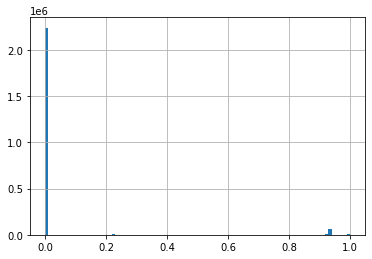

In [25]:
predictions_df["match_probability"].hist(bins=100)

<Axes: >

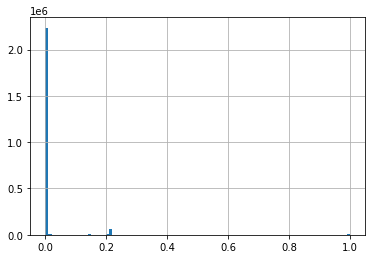

In [26]:
predictions_df["match_probability2"].hist(bins=100)

<Axes: >

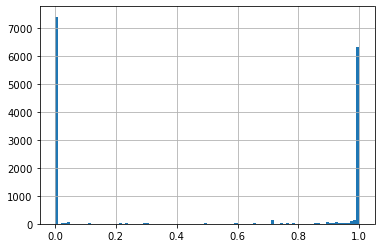

In [27]:
predictions_df[predictions_df["true_match"]]["match_probability"].hist(bins=100)

<Axes: >

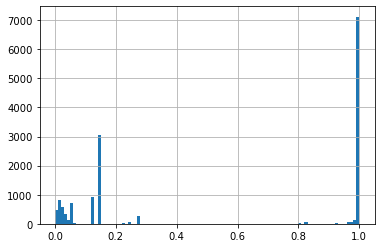

In [29]:
predictions_df[predictions_df["true_match"]]["match_probability2"].hist(bins=100)

<Axes: >

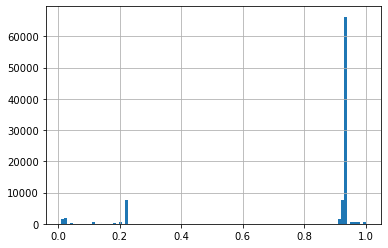

In [31]:
predictions_df[np.logical_and(predictions_df["true_match"]==False,predictions_df["match_probability"]>0.01)]["match_probability"].hist(bins=100)

<Axes: >

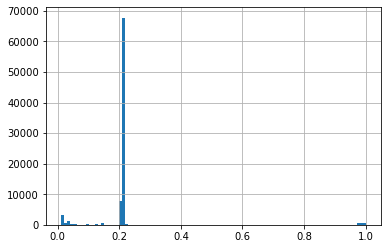

In [32]:
predictions_df[np.logical_and(predictions_df["true_match"]==False,predictions_df["match_probability2"]>0.01)]["match_probability2"].hist(bins=100)

model 2 is clearly better, but may not improve AUC ...

test estimate without term frequencies for semi-supervised

In [33]:
# setup as above
linker2_notf = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker2_notf.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker2_notf.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [34]:
# estimate with a semi-supervised rule
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker2_notf.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1}],
                                                                       comparisons_to_deactivate=[],
                                                                    estimate_without_term_frequencies=True
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"pcode_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on 

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 2: Largest change in params was 0.042 in the m_probability of lastname, level `Jaro_winkler >= 0.9 - front of string discrepdendies`
Iteration 3: Largest change in params was 0.026 in the m_probability of pcode, level `All other comparisons`
Iteration 4: Largest change in params was 0.0165 in the m_probability of pcode, level `All other comparisons`
Iteration 5: Largest change in params was 0.00979 in the m_probability of pcode, level `All other comparisons`
Iteration 6: Largest change in params was 0.00558 in the m_probability of pcode, level `All other comparisons`
Iteration 7: Largest change in params was 0.00312 in the m_probability of pcode, level `All other comparisons`
Iteration 8: Largest change in params was 0.00173 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.000964 in the m_probability of phonenum, level `All other comparisons`
Iteration 10: Largest change in params was 0.000534 in the m_probability of 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b42e16bf70>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42e17ba30>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42e17b730>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Larges

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 2: Largest change in params was -0.0818 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0547 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.0362 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.0229 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.0144 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -0.00919 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was -0.00599 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was -0.00397 in the m_probability of phonenum, level `All other comparisons`
Iteration 10: Largest change in params was -0.00267 in the m_probability of phonenum,

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b4244d1580>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b44afa9460>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428bd8550>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Iteration 1: Largest change in params was -0.616 in probability_two_random_records_match


Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 2: Largest change in params was 0.0423 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was 0.0511 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.0585 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0637 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was 0.0629 in the m_probability of firstname, level `Exact match on First Name`
Iteration 7: Largest change in params was 0.0528 in the m_probability of firstname, level `Exact match on First Name`
Iteration 8: Largest change in params was -0.0388 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was -0.0627 in the m_probability of lastname, level `All other comparisons`
Iteration 10: Largest change in params was -0.0804 in the m_prob

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42e2dcdf0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42e2dc2e0>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.292 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was -0.154 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0401 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00963 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.00229 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000535 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -0.000123 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was -2.79e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 8 iterations

Your model is fully trained. All comparisons have a

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b42e609850>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b42e609820>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42e609a60>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Iteration 1: Largest change in params was -0.249 in the m_probability of pcode, level `All other comparisons`


Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 2: Largest change in params was 0.0721 in the m_probability of pcode, level `Exact match`
Iteration 3: Largest change in params was 0.0121 in the m_probability of pcode, level `Exact match`
Iteration 4: Largest change in params was 0.00209 in the m_probability of pcode, level `Exact match`
Iteration 5: Largest change in params was 0.000456 in the m_probability of pcode, level `Exact match`
Iteration 6: Largest change in params was -0.000133 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -4.91e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b42e1fee50>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b42e1fea30>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42e1feb20>]


In [35]:
predictions2_notf_df = linker2_notf.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [36]:
predictions_df = predictions_df.merge( predictions2_notf_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight2_notf",
                                                         "match_probability":"match_probability2_notf"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [37]:
del predictions2_notf_df

In [38]:
from sklearn.metrics import roc_auc_score
# calculate precision-recall AUCs
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

In [39]:
roc_auc_score(y_true=predictions_df["true_match"], y_score=predictions_df["match_probability"])

0.9555458900113265

In [40]:
roc_auc_score(y_true=predictions_df["true_match"], y_score=predictions_df["match_probability2"])

0.9820054299312461

In [41]:
roc_auc_score(y_true=predictions_df["true_match"], y_score=predictions_df["match_probability2_notf"])

0.9820032643181146

In [42]:
#naive model, no semi-supervised rules
precision, recall, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability"])
auc(recall, precision)


0.47299021780217215

In [43]:
precision2, recall2, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability2"])
auc(recall2, precision2)


0.5720345125034185

In [44]:
precision2_notf, recall2_notf, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability2_notf"])
auc(recall2_notf, precision2_notf)


0.5720750684524905

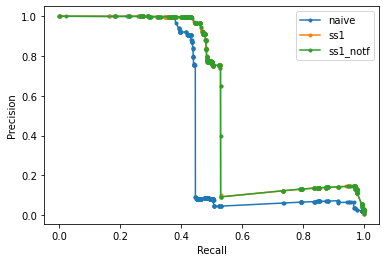

In [45]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall2_notf, precision2_notf, marker='.', label='ss1_notf')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

ok, big improvement in AUC but still there are all these potential false positives at 0.2 and false negatives below 0.2
see if more tweaking can be done via semi-supervised approach; 

Rather than rule-based, try random sample labelling:
* e.g. look at some of the false negatives and mark them as positives?
* e.g. look at some of the false postives and mark then as negatives?

Also potentially:
* e.g. adjust match probability for no name match rule up a bit from 0 for some blocks?

Also investigate whether these are office or doctor matches - to focus the diagnostics - could specify another rule if needed

Analyze gamma patterns

In [47]:
gammas2_df = predictions_df.value_counts(["match_probability2","gamma_firstname","gamma_lastname","gamma_pcode","gamma_phonenum","true_match"]).reset_index().sort_values("match_probability2")

In [48]:
gammas2_df[ np.logical_and( gammas2_df[0]>100, gammas2_df["match_probability2"]>0.01)]

,match_probability2,gamma_firstname,gamma_lastname,gamma_pcode,gamma_phonenum,true_match,0
77,0.011645,4,2,0,0,False,164
33,0.013353,1,4,0,0,False,770
84,0.013353,1,4,0,0,True,130
67,0.016723,5,3,0,0,False,226
89,0.016723,5,3,0,0,True,116
81,0.018280,3,3,0,0,False,142
46,0.019439,5,4,0,0,True,430
31,0.019439,5,4,0,0,False,854
74,0.019957,0,2,3,0,False,187
34,0.021243,3,4,0,0,False,747


Actually this is pretty good - the big chunk of false positives around 0.2 are all ruled by the semi-supervised rule.
And the big chunk of false negatives around 0.14 are high confidence matches on first and last name.
So two approaches may be used:
* another rule for high-confidence matches on first and last name
* manual exclusion of false positives ruled out by semi-supervised rule
First try adding another rule for high-confidence matches on first and last name.

In [49]:
# setup as above
linker3 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker3.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker3.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [50]:
# estimate with a semi-supervised rule
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker3.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1},
                                                                                             {"sql": """(gamma_firstname=6 or gamma_firstname=4) AND 
                                                                                                        (gamma_lastname=4 or gamma_lastname=3) """,
                                                                                   "match_probability": 1.0,
                                                                                   "omega":1}          
                                                                                                       
                                                                                                       ],
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"pcode_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Level first initial match on comparison firstname not observed in dataset, unable to train m value



Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b428560af0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b428560c70>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42dec7d00>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Largest

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b594cb8280>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b594cb8820>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b594cb8c70>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.593 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.0357 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was 0.0453 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.054 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0625 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was 0.0672 in the m_probability of firstname, level `Exact match on First Name`
Iteration 7: Largest change in params was 0.0626 in the m_probability of firstname, level `Exact match on First Name`
Iteration 8: Largest change in params was 0.0473 in the m_probability of firstname, level `Exact match on First Name`
Iteration 9: Largest change in params was -0.0338 in the m_probability of lastname, le

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4438f59a0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4438ed1c0>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.419 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was -0.148 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0357 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00689 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.00129 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.00024 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -4.46e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values

----- Starting EM training session -----

Estimating the m probabiliti

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b44392bbb0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b44392b160>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b44392b310>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.412 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.0997 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was 0.0122 in the m_probability of pcode, level `Exact match`
Iteration 4: Largest change in params was 0.0011 in the m_probability of pcode, level `Exact match`
Iteration 5: Largest change in params was 0.000105 in the m_probability of pcode, level `Exact match`
Iteration 6: Largest change in params was 9.99e-06 in the m_probability of pcode, level `Exact match`

EM converged after 6 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b59cd08880>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b59cd08700>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b59cd08a90>]


In [51]:
linker3.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [52]:
linker2.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Looks like an improvement over model 2 - weaker negative weights for pcode/phonenum, slightly weaker positive weights for them too


In [53]:
linker3.parameter_estimate_comparisons_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [54]:
predictions3_df = linker3.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [55]:
predictions_df = predictions_df.merge( predictions3_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight3",
                                                         "match_probability":"match_probability3"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [56]:
del predictions3_df

<Axes: >

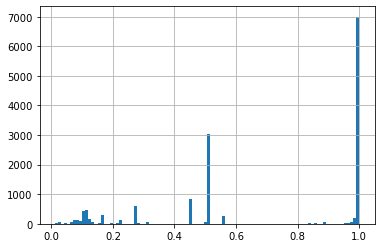

In [57]:
predictions_df[np.logical_and(predictions_df["true_match"]==True,predictions_df["match_probability3"]>0.01)]["match_probability3"].hist(bins=100)

<Axes: >

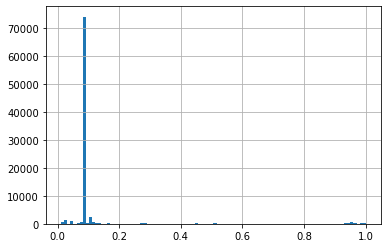

In [58]:
predictions_df[np.logical_and(predictions_df["true_match"]==False,predictions_df["match_probability3"]>0.01)]["match_probability3"].hist(bins=100)

MUCH better. Look at gamma patterns:

In [59]:
gammas3_df = predictions_df.value_counts(["match_probability3","gamma_firstname","gamma_lastname","gamma_pcode","gamma_phonenum","true_match"]).reset_index().sort_values("match_probability3")

In [60]:
gammas3_df[ np.logical_and( gammas3_df[0]>100, gammas3_df["match_probability3"]>0.01)]

,match_probability3,gamma_firstname,gamma_lastname,gamma_pcode,gamma_phonenum,true_match,0
78,0.015714,1,2,0,0,False,162
86,0.016644,5,1,0,0,False,125
38,0.022266,5,2,0,0,False,619
57,0.024031,3,2,0,0,False,282
74,0.028332,0,2,3,0,False,187
54,0.031133,1,0,3,0,False,331
42,0.043826,5,0,3,0,False,463
53,0.047218,3,0,3,0,False,342
77,0.066484,4,2,0,0,False,164
33,0.078298,1,4,0,0,False,770


In [61]:
roc_auc_score(y_true=predictions_df["true_match"], y_score=predictions_df["match_probability3"])

0.9960064851101258

In [62]:
precision3, recall3, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability3"])
auc(recall3, precision3)


0.8457438385511498

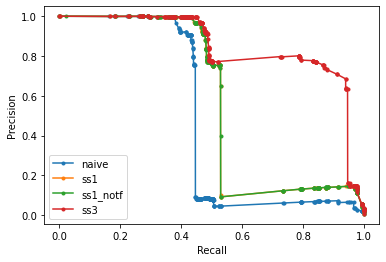

In [63]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall2_notf, precision2_notf, marker='.', label='ss1_notf')
pyplot.plot(recall3, precision3, marker='.', label='ss3')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

To check next
* see if TF can improve model
* more detailed diagnostics - e.g. per-doctor and office etc.

In [64]:
def make_tf_df(df, fname,enlist=False):
    # unnest and count values
    raw_counts = df[fname].value_counts()
    count_frame = raw_counts.to_frame(name="count").reset_index().rename(columns={"index":fname})
    count_frame["tf_"+fname] = count_frame["count"]/df.shape[0]
    if enlist:
        count_frame[fname] = count_frame[fname].apply(lambda x: [x])
    return count_frame

In [65]:
tf_fn = make_tf_df(doc_site_sim1_a,"firstname")
tf_ln = make_tf_df(doc_site_sim1_a,"lastname")
tf_pcode = make_tf_df(doc_site_sim1_a,"pcode")
tf_phonenum = make_tf_df(doc_site_sim1_a,"phonenum")


In [66]:
first_name_comparison_tf = {
    'output_column_name': 'firstname',
    'comparison_levels': [
        
        {
            'sql_condition': "firstname_l IS NULL OR firstname_r IS NULL",
            'label_for_charts': 'Null',
            'is_null_level': True
        },
        {
            'sql_condition': "firstname_l = firstname_r",
            'label_for_charts': 'Exact match on First Name', 
            #'m_probability': 0.70
          "tf_adjustment_column": "firstname",
          #  "tf_adjustment_weight": 1.0,
          # "tf_minimum_u_value": 0.0005
        },
        {
            'sql_condition': '(length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1))',
            'label_for_charts': 'first initial match', 
            #'m_probability': 0.15
            #"tf_adjustment_column": "first_name",
           # "tf_adjustment_weight": 1.0,
           # "tf_minimum_u_value": 0.0005

        },

        {
            'sql_condition': "jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9",
            'label_for_charts': 'Jaro_winkler >= 0.9 - name spelling discrepancies', 
            #'m_probability': 0.15
            "tf_adjustment_column": "firstname",
            #"tf_adjustment_weight": 1.0,
           # "tf_minimum_u_value": 0.0005,
            "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': "jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80", ## First Name Descrepency
            'label_for_charts': 'jaro_winkler >= 0.80 - name spelling discrepancies',
            #'m_probability': 0.05
            "tf_adjustment_column": "firstname",
            #"tf_adjustment_weight": 1.0,
            #"tf_minimum_u_value": 0.0005,
            "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': "damerau_levenshtein(firstname_l, firstname_r) <= 1",
            'label_for_charts': 'Damerau_levenshtein = 1 - one typos',
            "tf_adjustment_column": "firstname",
            #"tf_adjustment_weight": 1.0,
           # "tf_minimum_u_value": 0.0005,
            "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': "damerau_levenshtein(firstname_l, firstname_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 - two typos',
            "tf_adjustment_column": "firstname",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005,
            "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons',
            #'m_probability': 0.03 #### 
        }],
    
    'comparison_description': 'Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else'
}

last_name_comparison_tf = {
    'output_column_name': 'lastname',
    'comparison_levels': [
        
        {
            'sql_condition': "lastname_l IS NULL OR lastname_r IS NULL",
            'label_for_charts': 'Null',
            'is_null_level': True
        },
        {
            'sql_condition': "lastname_l = lastname_r",
            'label_for_charts': 'Exact match on Last Name', 
            #'m_probability': 0.70
            "tf_adjustment_column": "lastname",
            #"tf_adjustment_weight": 1.0,
            #"tf_minimum_u_value": 0.0005
        },

        {
            'sql_condition': "jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9",
            'label_for_charts': 'Jaro_winkler >= 0.9 - front of string discrepdendies', 
            #'m_probability': 0.15
            "tf_adjustment_column": "lastname",
            #"tf_adjustment_weight": 1.0,
            #"tf_minimum_u_value": 0.0005
            "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': "jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8", ## First Name Descrepency
            'label_for_charts': 'jaro_winkler >= 0.8 - name spelling discrepancies throughout str',
            # 'm_probability': 0.05
            "tf_adjustment_column": "lastname",
           # "tf_adjustment_weight": 1.0,
           # "tf_minimum_u_value": 0.0005
           "disable_tf_exact_match_detection": True

        },
       # {
       #     'sql_condition': "damerau_levenshtein(surname_l, surname_r) = 1",
       #     'label_for_charts': 'Damerau_levenshtein = 1 for typos',
       #     "tf_adjustment_column": "surname",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005

       # },
        {
            'sql_condition': "damerau_levenshtein(lastname_l, lastname_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 for typos',
            "tf_adjustment_column": "lastname",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005
           "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons',
            #'m_probability': 0.03 #### 
        }],
    
    'comparison_description': 'Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else'
}

pcode_comparison_tf = {
    'output_column_name': 'pcode',
    'comparison_levels': [
        
        {
            'sql_condition': " pcode_l is NULL OR pcode_r is NULL ",
            # 'sql_condition': 'Postal_Code_Array_l IS NULL OR Postal_Code_Array_r IS NULL',  
            'label_for_charts': 'Null',
            'is_null_level': True
        },

       {
            'sql_condition': "pcode_l=pcode_r",
            'label_for_charts': 'Exact match',
            "tf_adjustment_column": "pcode",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005
                       "disable_tf_exact_match_detection": True

        },
       {
            'sql_condition': "damerau_levenshtein(pcode_l, pcode_r) = 1",
            'label_for_charts': 'Damerau_levenshtein = 1 for typos',
           "tf_adjustment_column": "pcode",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005
                       "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': "damerau_levenshtein(pcode_l, pcode_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 for typos',
           # "tf_adjustment_column": "pcode",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005
          #  "disable_tf_exact_match_detection": True

        },
        
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons'
        }],

    'comparison_description': 'Null vs. exact vs D-L 1 vs D-L 2  vs. anything else'
}


phonenum_comparison_tf = {
    'output_column_name': 'phonenum',
    'comparison_levels': [
        
        {
            'sql_condition': " phonenum_l is NULL OR phonenum_r is NULL ",
            # 'sql_condition': 'Postal_Code_Array_l IS NULL OR Postal_Code_Array_r IS NULL',  
            'label_for_charts': 'Null',
            'is_null_level': True
        },

       {
            'sql_condition': "phonenum_l=phonenum_r",
            'label_for_charts': 'Exact match',
          "tf_adjustment_column": "phonenum",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005

        },
       {
            'sql_condition': "damerau_levenshtein(phonenum_l, phonenum_r) = 1",
            'label_for_charts': 'Damerau_levenshtein = 1 for typos',
           "tf_adjustment_column": "phonenum",
       #     "tf_adjustment_weight": 1.0,
       #     "tf_minimum_u_value": 0.0005
            "disable_tf_exact_match_detection": True

        },
        {
            'sql_condition': "damerau_levenshtein(phonenum_l, phonenum_r) = 2",
            'label_for_charts': 'Damerau_levenshtein = 2 for typos',
            "tf_adjustment_column": "phonenum",
           # "tf_adjustment_weight": 0.5,
           # "tf_minimum_u_value": 0.0005
           "disable_tf_exact_match_detection": True

        },
        
        {
            'sql_condition': 'ELSE', 
            'label_for_charts': 'All other comparisons'
        }],

    'comparison_description': 'Null vs. exact vs D-L 1 vs D-L 2  vs. anything else'
}


In [67]:
settings_tf = {
    "link_type": "link_only",
    
    "blocking_rules_to_generate_predictions": [

#        "len(array_intersect(l.postcode_fake, r.postcode_fake)) = 1",
        "right(l.pcode,2)=right(r.pcode,2)",
        "substr(l.phonenum,1,2)=substr(r.phonenum,1,2)", 
        #"size(array_intersect(l.City_Array, r.City_Array)) = 1 and substr(l.Last_Name, 1, 1) = substr(r.Last_Name, 1, 1)",
        "l.firstname = r.firstname", 
        "l.lastname = r.lastname",
        "substr(l.firstname, 1, 1) = substr(r.firstname, 1, 1) and substr(l.lastname, 1, 1) = substr(r.lastname, 1, 1)"
    ],

    

    "comparisons": [
        
        first_name_comparison_tf,

        last_name_comparison_tf, 

        pcode_comparison_tf,
        
        phonenum_comparison_tf#,

       # ctl.date_comparison("dob",cast_strings_to_date=True)
    
    ],
    
    "retain_matching_columns": True, 


    "retain_intermediate_calculation_columns": True,

    # "em_convergence": 0.01,

    "max_iterations": 50, ### fro review 

    "unique_id_column_name":'unique_id',
    
    "sql_dialect":'duckdb'}


In [68]:
# setup as above
linker4 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings_tf,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 

linker4.register_term_frequency_lookup(input_data=tf_fn[["firstname","tf_firstname"]], col_name="firstname",overwrite=True)
linker4.register_term_frequency_lookup(input_data=tf_ln[["lastname","tf_lastname"]], col_name="lastname",overwrite=True)
linker4.register_term_frequency_lookup(input_data=tf_pcode[["pcode","tf_pcode"]], col_name="pcode",overwrite=True)
linker4.register_term_frequency_lookup(input_data=tf_phonenum[["phonenum","tf_phonenum"]], col_name="phonenum",overwrite=True)

# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker4.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker4.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [69]:
# estimate with semi-supervised rules
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker4.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1},
                                                                                             {"sql": """(gamma_firstname=6 or gamma_firstname=4) AND 
                                                                                                        (gamma_lastname=4 or gamma_lastname=3) """,
                                                                                   "match_probability": 1.0,
                                                                                   "omega":1}          
                                                                                                       
                                                                                                       ],
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r","lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 EL

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on c

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b6eb4df940>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b6ade980a0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b6ade94130>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Largest

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b5b90beeb0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b5b90bed90>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b5b90beaf0>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.853 in the m_probability of firstname, level `All other comparisons`
Iteration 2: Largest change in params was -0.0999 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 3: Largest change in params was 0.13 in the m_probability of lastname, level `All other comparisons`
Iteration 4: Largest change in params was 0.0817 in the m_probability of lastname, level `All other comparisons`
Iteration 5: Largest change in params was 0.0355 in the m_probability of lastname, level `All other comparisons`
Iteration 6: Largest change in params was 0.0135 in the m_probability of lastname, level `All other comparisons`
Iteration 7: Largest change in params was 0.00531 in the m_probability of lastname, level `All other comparisons`
Iteration 8: Largest change in params was 0.00283 in the m_probability of firstname, level `first initial match`
Iteration 9: Largest change in params was 0.00191 in the m_probability of firstname, level `

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b5c5359bb0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b5c5359310>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r","lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL TH

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.889 in the m_probability of firstname, level `All other comparisons`
Iteration 2: Largest change in params was -0.146 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 3: Largest change in params was 0.0808 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.0712 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.0541 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.0324 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 0.0155 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was 0.00646 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.00255 in the m_probability of phonenum, level 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b43083e820>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b43082fd60>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b43081e760>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.78 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.118 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0148 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.00168 in the m_probability of pcode, level `Exact match`
Iteration 5: Largest change in params was -0.000189 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -2.13e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 6 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b43081e5b0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4308a85e0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4308cdac0>]


In [70]:
linker3.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [71]:
linker4.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Looks bad but this does NOT reflect TF weights. Have to check predictions to see impact of TF adjustments!!!!!

In [72]:
linker4.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [73]:
linker3.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [74]:
predictions4_df = linker4.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [75]:
predictions_df = predictions_df.merge( predictions4_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight4",
                                                         "match_probability":"match_probability4"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [76]:
del predictions4_df

<Axes: >

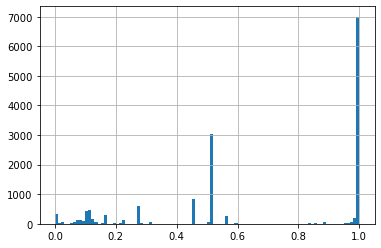

In [77]:
predictions_df[predictions_df["true_match"]==True]["match_probability3"].hist(bins=100)

<Axes: >

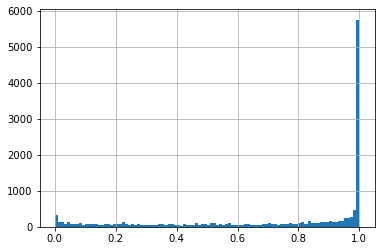

In [78]:
predictions_df[predictions_df["true_match"]==True]["match_probability4"].hist(bins=100)

<Axes: >

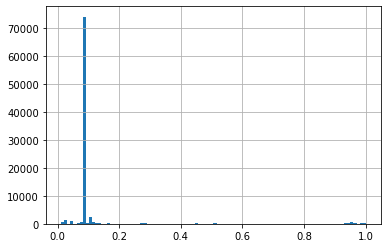

In [79]:
predictions_df[np.logical_and(predictions_df["true_match"]==False,predictions_df["match_probability3"]>0.01)]["match_probability3"].hist(bins=100)

<Axes: >

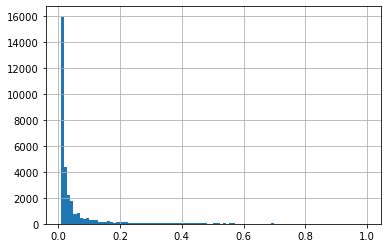

In [81]:
predictions_df[np.logical_and(predictions_df["true_match"]==False,predictions_df["match_probability4"]>0.01)]["match_probability4"].hist(bins=100)

In [82]:
roc_auc_score(y_true=predictions_df["true_match"], y_score=predictions_df["match_probability3"])

0.9960064851101258

In [83]:
roc_auc_score(y_true=predictions_df["true_match"], y_score=predictions_df["match_probability4"])

0.9983788755304426

moderate improvement in effective discrimination even if model looks bad

In [84]:
predictions_df.assign(above_20=predictions_df["match_probability3"]>0.2).value_counts(["above_20","true_match"]).\
                    reset_index().sort_values(["above_20","true_match"])

,above_20,true_match,0
0,False,False,2316346
3,False,True,2358
2,True,False,3745
1,True,True,12630


In [85]:
predictions_df.assign(above_20=predictions_df["match_probability4"]>0.2).value_counts(["above_20","true_match"]).\
                    reset_index().sort_values(["above_20","true_match"])

,above_20,true_match,0
0,False,False,2317757
3,False,True,1916
2,True,False,2334
1,True,True,13072


In [86]:
predictions_df.assign(above_50=predictions_df["match_probability3"]>0.5).value_counts(["above_50","true_match"]).\
                    reset_index().sort_values(["above_50","true_match"])

,above_50,true_match,0
0,False,False,2317315
2,False,True,4067
3,True,False,2776
1,True,True,10921


In [87]:
predictions_df.assign(above_50=predictions_df["match_probability4"]>0.5).value_counts(["above_50","true_match"]).\
                    reset_index().sort_values(["above_50","true_match"])

,above_50,true_match,0
0,False,False,2319297
2,False,True,3902
3,True,False,794
1,True,True,11086


In [88]:
#naive model, no semi-supervised rules
precision4, recall4, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability4"])
auc(recall4, precision4)

0.9286403166740931

Hurrah! Steady improvement.

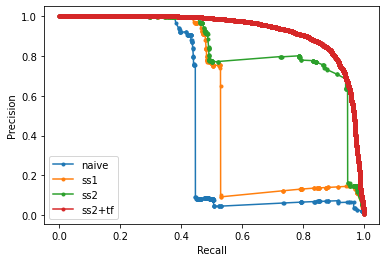

In [89]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall4, precision4, marker='.', label='ss2+tf')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Try model 4 with TF estimation turned off

In [90]:
# setup as above
linker5 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings_tf,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 

linker5.register_term_frequency_lookup(input_data=tf_fn[["firstname","tf_firstname"]], col_name="firstname",overwrite=True)
linker5.register_term_frequency_lookup(input_data=tf_ln[["lastname","tf_lastname"]], col_name="lastname",overwrite=True)
linker5.register_term_frequency_lookup(input_data=tf_pcode[["pcode","tf_pcode"]], col_name="pcode",overwrite=True)
linker5.register_term_frequency_lookup(input_data=tf_phonenum[["phonenum","tf_phonenum"]], col_name="phonenum",overwrite=True)

# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker5.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker5.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [91]:
# estimate with semi-supervised rules - but TURN OF TF FOR ESTIMATION
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker5.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1},
                                                                                             {"sql": """(gamma_firstname=6 or gamma_firstname=4) AND 
                                                                                                        (gamma_lastname=4 or gamma_lastname=3) """,
                                                                                   "match_probability": 1.0,
                                                                                   "omega":1}          
                                                                                                       
                                                                                                       ],
                                                                       comparisons_to_deactivate=[],
                                                                    estimate_without_term_frequencies=True
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r","lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 EL

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on 

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.997 in the u_probability of firstname, level `Exact match on First Name`
Iteration 2: Largest change in params was 0.0177 in the m_probability of pcode, level `All other comparisons`
Iteration 3: Largest change in params was -0.00643 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 4: Largest change in params was -0.00254 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 5: Largest change in params was -0.00102 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 6: Largest change in params was -0.000417 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 7: Largest change in params was -0.000173 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 8: Largest change in params was -7.31e-05 in the m_probability of lastname, level `Exact match on Last Name`

EM converged after 8 iterations

Your model is not yet fully 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b5d4782910>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b611ccb5b0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b611ccb190>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value



Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.997 in the u_probability of lastname, level `Exact match on Last Name`
Iteration 2: Largest change in params was 0.0849 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was 0.057 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.0337 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0174 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was 0.00827 in the m_probability of firstname, level `Exact match on First Name`
Iteration 7: Largest change in params was 0.00376 in the m_probability of firstname, level `Exact match on First Name`
Iteration 8: Largest change in params was 0.00168 in the m_probability of firstname, level `Exact match on First Name`
Iteration 9: Largest change in params was 0.000739 in the

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b647079130>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4438815e0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4438812e0>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Iteration 1: Largest change in params was -0.595 in probability_two_random_records_match


Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 2: Largest change in params was 0.034 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was 0.0436 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.0525 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0615 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was 0.0674 in the m_probability of firstname, level `Exact match on First Name`
Iteration 7: Largest change in params was 0.0646 in the m_probability of firstname, level `Exact match on First Name`
Iteration 8: Largest change in params was 0.0506 in the m_probability of firstname, level `Exact match on First Name`
Iteration 9: Largest change in params was 0.0311 in the m_probability of firstname, level `Exact match on First Name`
Iteration 10: Largest change in params was -0.0481 in the

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b59cd05310>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b59cd059d0>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r","lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL TH

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.418 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was -0.149 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0372 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00734 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.00139 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000264 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -4.98e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values

----- Starting EM training session -----

Estimating the m probabili

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b443809640>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b430b13100>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430b1e970>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.411 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.101 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was 0.0126 in the m_probability of pcode, level `Exact match`
Iteration 4: Largest change in params was 0.00116 in the m_probability of pcode, level `Exact match`
Iteration 5: Largest change in params was 0.000111 in the m_probability of pcode, level `Exact match`
Iteration 6: Largest change in params was 1.08e-05 in the m_probability of pcode, level `Exact match`

EM converged after 6 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b430b1eca0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b76133d880>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b76133d3d0>]


In [92]:
linker5.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [93]:
predictions5_df = linker5.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [94]:
predictions_df = predictions_df.merge( predictions5_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight5",
                                                         "match_probability":"match_probability5"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [95]:
#naive model, no semi-supervised rules
precision5, recall5, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability5"])
auc(recall5, precision5)

0.8233684735810373

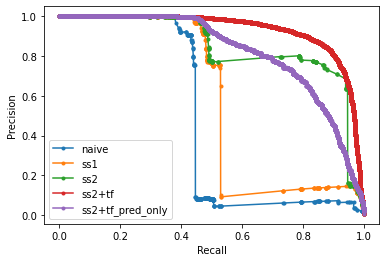

In [96]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall4, precision4, marker='.', label='ss2+tf')
pyplot.plot(recall5, precision5, marker='.', label='ss2+tf_pred_only')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Using TF for prediction only degrades performance a lot - worse than no TF for some parts of the curve and overall AUC.

Next - can TF help naive model or ss1 model?

In [98]:
# setup as above
linker6 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings_tf,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 

linker6.register_term_frequency_lookup(input_data=tf_fn[["firstname","tf_firstname"]], col_name="firstname",overwrite=True)
linker6.register_term_frequency_lookup(input_data=tf_ln[["lastname","tf_lastname"]], col_name="lastname",overwrite=True)
linker6.register_term_frequency_lookup(input_data=tf_pcode[["pcode","tf_pcode"]], col_name="pcode",overwrite=True)
linker6.register_term_frequency_lookup(input_data=tf_phonenum[["phonenum","tf_phonenum"]], col_name="phonenum",overwrite=True)

# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker6.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker6.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [100]:
# estimate without semi-supervised rules but with TF
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker6.estimate_parameters_using_expectation_maximisation(blocking_rules[i])
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"tf_lastname_l","tf_lastname_r",CASE WHEN  pcode_l is NULL OR pcode_r is NULL  THEN -1 WHEN pcode_l=pcode_r THEN 3 WHEN damerau_levenshtein(pcode_l, pcode_r) = 1 THEN 2 WHEN damerau_levenshtein(pcode_l, pcode_r) = 2 THEN 1 ELSE 0 END as gamma_pcode,"tf_pcode_l","tf_pcode_r",CASE WHEN  phonenum_l is NULL OR phonenum_r is NULL  THEN -1 WHEN phonenum_l=phonenum_r THEN 3 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 1 THEN 2 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 2 THEN 1 ELSE 0 END as gamma_phonenum,"tf_phonenum_l","tf_phonenum_r",match_key 
    from __splink_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_lastname', 'tf_lastname_l', 'tf_lastname_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'gamma_phonenum', 'tf_phonenum_l',
       'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.278 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 2: Largest change in params was -0.0285 in the m_probability of phonenum, level `Exact match`
Iteration 3: Largest change in params was 0.025 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.032 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.047 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.0654 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 0.0712 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was 0.0556 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.0333 in the m_probability of phonenum, level `All other compa

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b430baff40>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430baf340>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430baf250>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'gamma_phonenum', 'tf_phonenum_l',
       'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.226 in the m_probability of firstname, level `Exact match on First Name`
Iteration 2: Largest change in params was -0.0547 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was -0.0111 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.00283 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.00202 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.0015 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 0.00115 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was 0.000885 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.000685 in the m_probability of

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b430c88c70>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430c88be0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430c885b0>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN  pcode_l is NULL OR pcode_r is NULL  THEN -1 WHEN pcode_l=pcode_r THEN 3 WHEN damerau_levenshtein(pcode_l, pcode_r) = 1 THEN 2 WHEN damerau_levenshtein(pcode_l, pcode_r) = 2 THEN 1 ELSE 0 END as gamma_pcode,"tf_pcode_l","tf_pcode_r",CASE WHEN  phonenum_l is NULL OR phonenum_r is NULL  THEN -1 WHEN phonenum_l=phonenum_r THEN 3 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 1 THEN 2 WHEN damerau_levenshtein(phonenum_l, phonenum_r) = 2 THEN 1 ELSE 0 END as gamma_phonenum,"tf_phonenum_l","tf_phonenum_r",m

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_pcode', 'tf_pcode_l', 'tf_pcode_r', 'gamma_phonenum',
       'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.547 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was 0.0105 in the m_probability of pcode, level `All other comparisons`
Iteration 3: Largest change in params was -0.00862 in probability_two_random_records_match
Iteration 4: Largest change in params was -0.00864 in probability_two_random_records_match
Iteration 5: Largest change in params was -0.0088 in probability_two_random_records_match
Iteration 6: Largest change in params was -0.00899 in probability_two_random_records_match
Iteration 7: Largest change in params was -0.00919 in probability_two_random_records_match
Iteration 8: Largest change in params was -0.0094 in probability_two_random_records_match
Iteration 9: Largest change in params was -0.00962 in probability_two_random_records_match
Iteration 10: Largest change in params was -0.00984 in probability_two_random_records_match
Iteration 11: Largest change in params was -0.0101 

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430e04250>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430e04be0>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_wi

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'gamma_phonenum', 'tf_phonenum_l',
       'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.286 in the m_probability of lastname, level `All other comparisons`
Iteration 2: Largest change in params was 0.419 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was 0.191 in the m_probability of firstname, level `All other comparisons`
Iteration 4: Largest change in params was 0.0227 in the m_probability of firstname, level `All other comparisons`
Iteration 5: Largest change in params was -0.0138 in the m_probability of phonenum, level `Exact match`
Iteration 6: Largest change in params was -0.00697 in the m_probability of phonenum, level `Exact match`
Iteration 7: Largest change in params was -0.00308 in the m_probability of phonenum, level `Exact match`
Iteration 8: Largest change in params was -0.00153 in the m_probability of phonenum, level `Exact match`
Iteration 9: Largest change in params was -0.000974 in the m_probability of phonenum, level `Exact match`
Iteration 10: Largest c

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b430de5040>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b430e865b0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430e99d00>]

 5 estimation pass....


Estimating the m probabilities of the model by blocking on:
substr(l.phonenum,1,2)=substr(r.phonenum,1,2)

Parameter estimates will be made for the following comparison(s):
    - firstname
    - lastname
    - pcode

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - phonenum



    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"tf_lastname_l","tf_lastname_r",CASE WHEN  pcode_l 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'gamma_pcode', 'tf_pcode_l',
       'tf_pcode_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.382 in the m_probability of lastname, level `All other comparisons`
Iteration 2: Largest change in params was 0.0526 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was 0.0261 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 4: Largest change in params was 0.00683 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 5: Largest change in params was 0.00144 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 6: Largest change in params was -0.000865 in the m_probability of pcode, level `All other comparisons`
Iteration 7: Largest change in params was -0.000812 in the m_probability of pcode, level `All other comparisons`
Iteration 8: Largest change in params was -0.000774 in the m_probability of pcode, level `All other comparisons`
Iteration 9: Largest change in params was -0.000739 in the m_probab

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b430f69c40>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b430faabb0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430faaeb0>]


In [101]:
predictions6_df = linker6.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [102]:
predictions_df = predictions_df.merge( predictions6_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight6",
                                                         "match_probability":"match_probability6"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [105]:
del predictions6_df

In [103]:
#naive model, no semi-supervised rules
precision6, recall6, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability6"])
auc(recall6, precision6)

0.45736368883288847

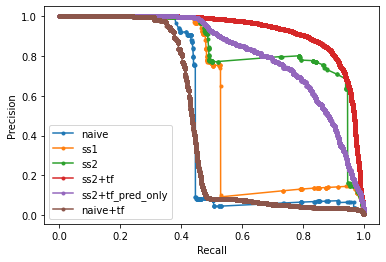

In [104]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall4, precision4, marker='.', label='ss2+tf')
pyplot.plot(recall5, precision5, marker='.', label='ss2+tf_pred_only')
pyplot.plot(recall6, precision6, marker='.', label='naive+tf')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next try this also  with comparisons_to_deactivate=[] -- might fix the bad blocks....

In [106]:
# setup as above
linker7 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings_tf,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 

linker7.register_term_frequency_lookup(input_data=tf_fn[["firstname","tf_firstname"]], col_name="firstname",overwrite=True)
linker7.register_term_frequency_lookup(input_data=tf_ln[["lastname","tf_lastname"]], col_name="lastname",overwrite=True)
linker7.register_term_frequency_lookup(input_data=tf_pcode[["pcode","tf_pcode"]], col_name="pcode",overwrite=True)
linker7.register_term_frequency_lookup(input_data=tf_phonenum[["phonenum","tf_phonenum"]], col_name="phonenum",overwrite=True)

# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker7.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker7.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [107]:
# estimate without semi-supervised rules but with TF
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker7.estimate_parameters_using_expectation_maximisation(blocking_rules[i], comparisons_to_deactivate=[])
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"tf_lastname_l","tf_lastnam

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'gamma_pcode', 'tf_pcode_l',
       'tf_pcode_r', 'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r',
       'match_key'],
      dtype='object')


Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on c

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4319e7250>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b73d6c7310>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430bd97c0>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'gamma_pcode', 'tf_pcode_l',
       'tf_pcode_r', 'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r',
       'match_key'],
      dtype='object')


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Largest

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b434e09fa0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b434e09580>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b434e09bb0>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'gamma_pcode', 'tf_pcode_l',
       'tf_pcode_r', 'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r',
       'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.668 in the m_probability of firstname, level `All other comparisons`
Iteration 2: Largest change in params was 0.113 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was 0.0979 in the m_probability of lastname, level `All other comparisons`
Iteration 4: Largest change in params was 0.0605 in the m_probability of lastname, level `All other comparisons`
Iteration 5: Largest change in params was 0.0292 in the m_probability of lastname, level `All other comparisons`
Iteration 6: Largest change in params was 0.0195 in the m_probability of firstname, level `All other comparisons`
Iteration 7: Largest change in params was 0.0162 in the m_probability of firstname, level `All other comparisons`
Iteration 8: Largest change in params was 0.0127 in the m_probability of firstname, level `All other comparisons`
Iteration 9: Largest change in params was 0.00976 in the m_probability of firstname, level `A

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b93fddda60>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b93fddd2e0>]

 4 estimation pass....


Estimating the m probabilities of the model by blocking on:
right(l.pcode,2)=right(r.pcode,2)

Parameter estimates will be made for the following comparison(s):
    - firstname
    - lastname
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - pcode



    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"tf_lastname_l","tf_lastname_r",CASE WHEN  pcode_l 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'gamma_pcode', 'tf_pcode_l',
       'tf_pcode_r', 'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r',
       'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.819 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was 0.274 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was 0.364 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.181 in the m_probability of pcode, level `Damerau_levenshtein = 1 for typos`
Iteration 5: Largest change in params was -0.0168 in the m_probability of pcode, level `Exact match`
Iteration 6: Largest change in params was 0.00118 in the u_probability of pcode, level `All other comparisons`
Iteration 7: Largest change in params was 0.00055 in the m_probability of pcode, level `Damerau_levenshtein = 2 for typos`
Iteration 8: Largest change in params was 0.000456 in the m_probability of pcode, level `Damerau_levenshtein = 2 for typos`
Iteration 9: Largest change in params was 0.000372 in the m_probability of pcode, lev

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b93fde9130>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b434edac10>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b434edaf40>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN da

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'tf_firstname_l', 'tf_firstname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'gamma_pcode', 'tf_pcode_l',
       'tf_pcode_r', 'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r',
       'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.856 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was 0.0941 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was -0.00653 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00307 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.00163 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000906 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -0.000521 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was -0.000308 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was -0.000187 in the m_probability of phon

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b434ec13a0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b443a13b80>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b443a13100>]


WOW this gets rid of convergence problems too....

In [108]:
predictions7_df = linker7.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [109]:
predictions_df = predictions_df.merge( predictions7_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight7",
                                                         "match_probability":"match_probability7"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [110]:
del predictions7_df

In [111]:
#naive model, no semi-supervised rules
precision7, recall7, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability7"])
auc(recall7, precision7)

0.5425333574904284

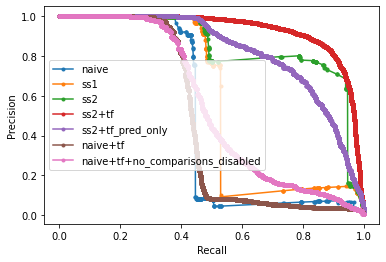

In [112]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall4, precision4, marker='.', label='ss2+tf')
pyplot.plot(recall5, precision5, marker='.', label='ss2+tf_pred_only')
pyplot.plot(recall6, precision6, marker='.', label='naive+tf')
pyplot.plot(recall7, precision7, marker='.', label='naive+tf+no_comparisons_disabled')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

try naive + no comparisons disabled without TF

In [113]:
# setup as above
linker8 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 

# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker8.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker8.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [114]:
# estimate without semi-supervised rules but with TF
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker8.estimate_parameters_using_expectation_maximisation(blocking_rules[i], comparisons_to_deactivate=[])
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,CASE WHEN  pcode_l is NULL OR pcode_r is NULL  THEN -1 WHEN p

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on 

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_lastname', 'gamma_pcode', 'gamma_phonenum',
       'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.997 in the u_probability of firstname, level `Exact match on First Name`
Iteration 2: Largest change in params was 0.045 in the m_probability of pcode, level `All other comparisons`
Iteration 3: Largest change in params was 0.0291 in the m_probability of pcode, level `All other comparisons`
Iteration 4: Largest change in params was 0.0178 in the m_probability of pcode, level `All other comparisons`
Iteration 5: Largest change in params was 0.01 in the m_probability of pcode, level `All other comparisons`
Iteration 6: Largest change in params was 0.00543 in the m_probability of pcode, level `All other comparisons`
Iteration 7: Largest change in params was 0.00289 in the m_probability of pcode, level `All other comparisons`
Iteration 8: Largest change in params was 0.00154 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.000821 in the m_probability of phonenum, level `All other comparis

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b430e39f70>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b59c94edf0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b59c94e730>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_lastname', 'gamma_pcode', 'gamma_phonenum',
       'match_key'],
      dtype='object')


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Largest

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b59c93dfa0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b59c954670>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b59c9548e0>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,C

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_lastname', 'gamma_pcode', 'gamma_phonenum',
       'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.61 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.0606 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was 0.0273 in the m_probability of firstname, level `All other comparisons`
Iteration 4: Largest change in params was 0.0236 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0258 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was 0.0269 in the m_probability of firstname, level `Exact match on First Name`
Iteration 7: Largest change in params was 0.0271 in the m_probability of firstname, level `Exact match on First Name`
Iteration 8: Largest change in params was 0.0268 in the m_probability of firstname, level `Exact match on First Name`
Iteration 9: Largest change in params was 0.0264 in the m_probability of firstname, level `Exa

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b443bf60a0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b443c11790>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastn

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_lastname', 'gamma_pcode', 'gamma_phonenum',
       'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.821 in the m_probability of lastname, level `All other comparisons`
Iteration 2: Largest change in params was 0.0359 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was -0.00808 in the m_probability of pcode, level `Exact match`
Iteration 4: Largest change in params was 0.00125 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.0012 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.00113 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 0.00107 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was 0.001 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.000944 in the m_probability of phonenum, level `All other com

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b443c325b0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b443d06940>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b443d034c0>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN da

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'gamma_firstname', 'gamma_lastname', 'gamma_pcode', 'gamma_phonenum',
       'match_key'],
      dtype='object')


Iteration 1: Largest change in params was 0.421 in the m_probability of firstname, level `All other comparisons`
Iteration 2: Largest change in params was -0.0219 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.00506 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00152 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.000524 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000195 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 9.02e-05 in the m_probability of pcode, level `Exact match`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b443de9a90>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b443de9340>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b443de9a60>]


In [115]:
predictions8_df = linker8.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [116]:
predictions_df = predictions_df.merge( predictions8_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight8",
                                                         "match_probability":"match_probability8"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [117]:
del predictions8_df

In [118]:
#naive model, no semi-supervised rules
precision8, recall8, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability8"])
auc(recall8, precision8)

0.47090749057872344

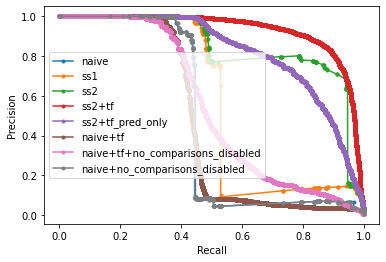

In [119]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall4, precision4, marker='.', label='ss2+tf')
pyplot.plot(recall5, precision5, marker='.', label='ss2+tf_pred_only')
pyplot.plot(recall6, precision6, marker='.', label='naive+tf')
pyplot.plot(recall7, precision7, marker='.', label='naive+tf+no_comparisons_disabled')
pyplot.plot(recall8, precision8, marker='.', label='naive+no_comparisons_disabled')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Interesting - not disabling comparisons allowed convergence but gave essentially same PR curve as naive.
Try SS1 + TF

In [120]:
# setup as above
linker9 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings_tf,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 

linker9.register_term_frequency_lookup(input_data=tf_fn[["firstname","tf_firstname"]], col_name="firstname",overwrite=True)
linker9.register_term_frequency_lookup(input_data=tf_ln[["lastname","tf_lastname"]], col_name="lastname",overwrite=True)
linker9.register_term_frequency_lookup(input_data=tf_pcode[["pcode","tf_pcode"]], col_name="pcode",overwrite=True)
linker9.register_term_frequency_lookup(input_data=tf_phonenum[["phonenum","tf_phonenum"]], col_name="phonenum",overwrite=True)

# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker9.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker9.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [121]:
# estimate with semi-supervised rules
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker9.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1}
                                                                                                       
                                                                                                       ],
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r","lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 EL

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on c

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b75a508df0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b430b87310>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b44390d6d0>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Largest

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b43a7540d0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b611cbe280>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b611cbe310>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.843 in the m_probability of firstname, level `All other comparisons`
Iteration 2: Largest change in params was 0.132 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was 0.133 in the m_probability of lastname, level `All other comparisons`
Iteration 4: Largest change in params was 0.088 in the m_probability of lastname, level `All other comparisons`
Iteration 5: Largest change in params was 0.0387 in the m_probability of lastname, level `All other comparisons`
Iteration 6: Largest change in params was 0.0147 in the m_probability of lastname, level `All other comparisons`
Iteration 7: Largest change in params was 0.00562 in the m_probability of lastname, level `All other comparisons`
Iteration 8: Largest change in params was 0.00294 in the m_probability of firstname, level `first initial match`
Iteration 9: Largest change in params was 0.00199 in the m_probability of firstname, level `first

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b64d0bc3a0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b42c9d3be0>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"tf_firstname_l","tf_firstname_r","lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL TH

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.895 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.143 in the m_probability of lastname, level `Exact match on Last Name`
Iteration 3: Largest change in params was 0.0783 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.0713 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.056 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 0.035 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was 0.0173 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was 0.0074 in the m_probability of phonenum, level `All other comparisons`
Iteration 9: Largest change in params was 0.00299 in the m_probability of phonenum, level `All

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b411d1f8b0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4310d87c0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b6bf50d880>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'tf_firstname_l',
       'tf_firstname_r', 'lastname_l', 'lastname_r', 'gamma_lastname',
       'tf_lastname_l', 'tf_lastname_r', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'tf_pcode_l', 'tf_pcode_r', 'phonenum_l', 'phonenum_r',
       'gamma_phonenum', 'tf_phonenum_l', 'tf_phonenum_r', 'match_key'],
      dtype='object')


Iteration 1: Largest change in params was -0.781 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.118 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0184 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00406 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.00118 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000417 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -0.000169 in the m_probability of phonenum, level `All other comparisons`
Iteration 8: Largest change in params was -7.41e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 8 iterations

Your model is fully trained. All comparisons hav

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b6bf50de50>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b594c4a700>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b75a503f10>]


In [122]:
predictions9_df = linker9.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [123]:
predictions_df = predictions_df.merge( predictions9_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight9",
                                                         "match_probability":"match_probability9"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [124]:
del predictions9_df

In [126]:

precision9, recall9, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability9"])
auc(recall9, precision9)

0.9284506660578375

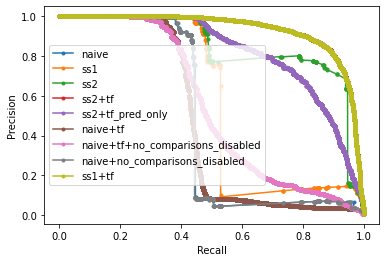

In [127]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall4, precision4, marker='.', label='ss2+tf')
pyplot.plot(recall5, precision5, marker='.', label='ss2+tf_pred_only')
pyplot.plot(recall6, precision6, marker='.', label='naive+tf')
pyplot.plot(recall7, precision7, marker='.', label='naive+tf+no_comparisons_disabled')
pyplot.plot(recall8, precision8, marker='.', label='naive+no_comparisons_disabled')
pyplot.plot(recall9, precision9, marker='.', label='ss1+tf')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

WEIRD - SS1+TF basically the same as SS2+TF - maybe because TF rules things in like the second semi-supervised rule says.
Check out parameter estimates.

In [128]:
linker9.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [129]:
linker9.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [130]:
linker4.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


Now try a random sample of as-yet-unlabelled data to augment - simulating clerical review

In [134]:
gammas3_df_all = predictions_df.value_counts(["match_probability3","gamma_firstname","gamma_lastname","gamma_pcode","gamma_phonenum","true_match"]).reset_index().sort_values("match_probability3")

In [135]:
gammas3_df_all["ss1"]= np.logical_and(gammas3_df_all["gamma_firstname"]==0,
                                      gammas3_df_all["gamma_lastname"]==0)
gammas3_df_all["ss2"] = np.logical_and( np.logical_or(gammas3_df_all["gamma_firstname"]==6, 
                                                      gammas3_df_all["gamma_firstname"]==4),
                                        np.logical_or(gammas3_df_all["gamma_lastname"]==4,
                                                      gammas3_df_all["gamma_lastname"]==3)
                                      )

In [136]:
ss_candidates = gammas3_df_all[ np.logical_and(gammas3_df_all["ss1"]==False,
                                              gammas3_df_all["ss2"]==False)]

In [138]:
predictions_df["ss1"]= np.logical_and(predictions_df["gamma_firstname"]==0,
                                      predictions_df["gamma_lastname"]==0)
predictions_df["ss2"] = np.logical_and( np.logical_or(predictions_df["gamma_firstname"]==6, 
                                                      predictions_df["gamma_firstname"]==4),
                                        np.logical_or(predictions_df["gamma_lastname"]==4,
                                                      predictions_df["gamma_lastname"]==3)
                                      )

array([[<Axes: title={'center': 'match_probability3'}>]], dtype=object)

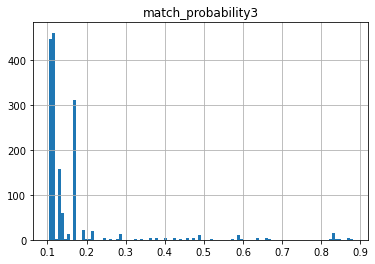

In [139]:
predictions_df[ np.logical_and( np.logical_and(predictions_df["ss2"]==False,predictions_df["ss1"]==False),
                                np.logical_and( np.logical_and(predictions_df["match_probability3"]>0.1, predictions_df["match_probability3"]<0.9),
                                              predictions_df["true_match"])
                              )].hist("match_probability3",bins=100)

array([[<Axes: title={'center': 'match_probability3'}>]], dtype=object)

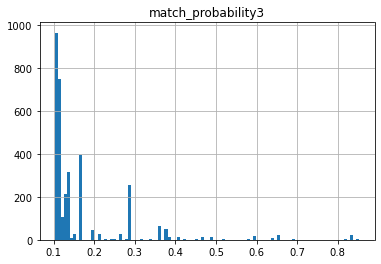

In [140]:
predictions_df[ np.logical_and( np.logical_and(predictions_df["ss2"]==False,predictions_df["ss1"]==False),
                                np.logical_and( np.logical_and(predictions_df["match_probability3"]>0.1, predictions_df["match_probability3"]<0.9),
                                              predictions_df["true_match"]==False)
                              )].hist("match_probability3",bins=100)

In [141]:
ss_sample_df = predictions_df[ np.logical_and( np.logical_and(predictions_df["ss2"]==False,predictions_df["ss1"]==False),
                             np.logical_and(predictions_df["match_probability3"]>0.1, predictions_df["match_probability3"]<0.9)
                              )].sample(1000)

array([[<Axes: title={'center': 'match_probability3'}>]], dtype=object)

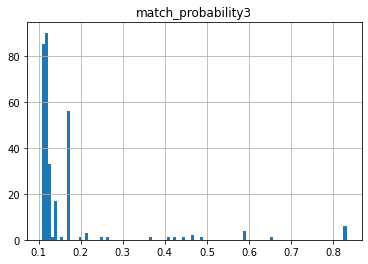

In [143]:
ss_sample_df[ ss_sample_df["true_match"]].hist("match_probability3",bins=100)

array([[<Axes: title={'center': 'match_probability3'}>]], dtype=object)

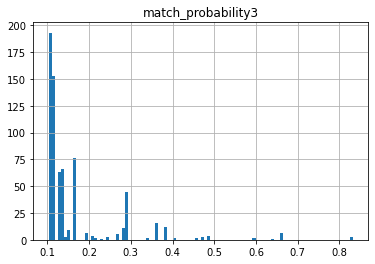

In [144]:
ss_sample_df[ ss_sample_df["true_match"]==False].hist("match_probability3",bins=100)

In [145]:
ss_sample_df.value_counts("true_match")

true_match
False    693
True     307
dtype: int64

In [153]:
ss_table = ss_sample_df[ ["unique_id_l","unique_id_r","source_dataset_r","source_dataset_l", "true_match"]].assign(
                                                    semi_supervised_match_probability=ss_sample_df["true_match"].astype("float"),
                                                    semi_supervised_omega = 1)

In [166]:
# setup as above
linker10 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker10.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker10.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [167]:
# estimate with a semi-supervised rule
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker10.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1},
                                                                                             {"sql": """(gamma_firstname=6 or gamma_firstname=4) AND 
                                                                                                        (gamma_lastname=4 or gamma_lastname=3) """,
                                                                                   "match_probability": 1.0,
                                                                                   "omega":1}          
                                                                                                       
                                                                                                       ],
                                                                        semi_supervised_table=ss_table,
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"pcode_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2bafa442790>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2bafa442430>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2bafa448040>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Larges

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b6eacb1a00>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b6eacb8820>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b6eacb8190>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.59 in probability_two_random_records_match
Iteration 2: Largest change in params was 0.0402 in the m_probability of firstname, level `Exact match on First Name`
Iteration 3: Largest change in params was 0.0531 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.0648 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0722 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was 0.0694 in the m_probability of firstname, level `Exact match on First Name`
Iteration 7: Largest change in params was 0.0554 in the m_probability of firstname, level `Exact match on First Name`
Iteration 8: Largest change in params was -0.0416 in the m_probability of lastname, level `All other comparisons`
Iteration 9: Largest change in params was -0.0587 in the m_probability of lastname, level

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b44c2987c0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b44c2987f0>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.425 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was -0.143 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0308 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00519 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.000849 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000139 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -2.26e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values

----- Starting EM training session -----

Estimating the m probabil

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b68af717f0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b565f47af0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4438470a0>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.419 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.0987 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was 0.0111 in the m_probability of pcode, level `Exact match`
Iteration 4: Largest change in params was 0.000899 in the m_probability of pcode, level `Exact match`
Iteration 5: Largest change in params was 7.54e-05 in the m_probability of pcode, level `Exact match`

EM converged after 5 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b43a7144c0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b75a50f3a0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b75a50fe50>]


convergence problems ....

In [175]:
linker10.parameter_estimate_comparisons_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [176]:
predictions10_df = linker10.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [179]:
predictions_df = predictions_df.merge( predictions10_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight10",
                                                         "match_probability":"match_probability10"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [181]:
auc(recall3,precision3)

0.8457438385511498

In [180]:

precision10, recall10, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability10"])
auc(recall10, precision10)

0.8507860969020873

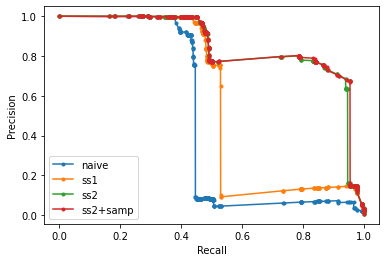

In [182]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall10, precision10, marker='.', label='ss2+samp')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [184]:
try up-weighting samp

SyntaxError: invalid syntax (456851175.py, line 1)

In [193]:
# setup as above
linker11 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker11.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker11.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [194]:
ss_table_10 = ss_table.assign(semi_supervised_omega=10)

In [195]:
# estimate with a semi-supervised rule
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker11.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1},
                                                                                             {"sql": """(gamma_firstname=6 or gamma_firstname=4) AND 
                                                                                                        (gamma_lastname=4 or gamma_lastname=3) """,
                                                                                   "match_probability": 1.0,
                                                                                   "omega":1}          
                                                                                                       
                                                                                                       ],
                                                                        semi_supervised_table=ss_table_10,
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"pcode_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b452288970>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b452288820>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b452288af0>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Larges

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b4522ce070>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4522dc1f0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2bc396b05e0>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.526 in probability_two_random_records_match
Iteration 2: Largest change in params was -0.0549 in the m_probability of firstname, level `All other comparisons`
Iteration 3: Largest change in params was 0.0596 in the m_probability of firstname, level `Exact match on First Name`
Iteration 4: Largest change in params was 0.0629 in the m_probability of firstname, level `Exact match on First Name`
Iteration 5: Largest change in params was 0.0582 in the m_probability of firstname, level `Exact match on First Name`
Iteration 6: Largest change in params was -0.056 in the m_probability of lastname, level `All other comparisons`
Iteration 7: Largest change in params was -0.0675 in the m_probability of lastname, level `All other comparisons`
Iteration 8: Largest change in params was -0.0757 in the m_probability of lastname, level `All other comparisons`
Iteration 9: Largest change in params was -0.0769 in the m_probability of lastname, level `All other

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b67b1b24c0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4522f0820>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.483 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was -0.148 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0333 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00573 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.000932 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.00015 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -2.42e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values

----- Starting EM training session -----

Estimating the m probabili

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b67b195fd0>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b67b1958b0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4523888b0>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.468 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.109 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0134 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was 0.00106 in the m_probability of pcode, level `Exact match`
Iteration 5: Largest change in params was 8.68e-05 in the m_probability of pcode, level `Exact match`

EM converged after 5 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2bc396c5760>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2bbdc9cfb50>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2bc396c5cd0>]


In [207]:
predictions11_df = linker11.predict().as_pandas_dataframe()

In [208]:
predictions_df = predictions_df.merge( predictions11_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight11",
                                                         "match_probability":"match_probability11"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [209]:
del predictions11_df

In [210]:

precision11, recall11, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability11"])
auc(recall11, precision11)

0.8595987346404128

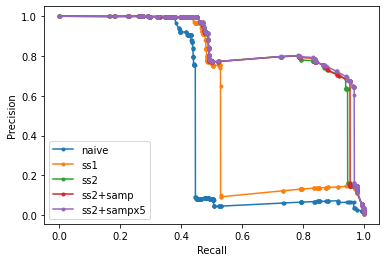

In [211]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall10, precision10, marker='.', label='ss2+samp')
pyplot.plot(recall11, precision11, marker='.', label='ss2+sampx5')

# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [212]:
# setup as above
linker12 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker12.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker12.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [213]:
ss_table_100 = ss_table.assign(semi_supervised_omega=100)

In [214]:
# estimate with a semi-supervised rule
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker12.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1},
                                                                                             {"sql": """(gamma_firstname=6 or gamma_firstname=4) AND 
                                                                                                        (gamma_lastname=4 or gamma_lastname=3) """,
                                                                                   "match_probability": 1.0,
                                                                                   "omega":1}          
                                                                                                       
                                                                                                       ],
                                                                        semi_supervised_table=ss_table_100,
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"pcode_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b6ef9baac0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2bbc365ce20>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2bbc365c9a0>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Larges

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b45784f760>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b457859550>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b457859280>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was 0.299 in the m_probability of lastname, level `All other comparisons`
Iteration 2: Largest change in params was -0.095 in the m_probability of lastname, level `All other comparisons`
Iteration 3: Largest change in params was -0.0966 in the m_probability of lastname, level `All other comparisons`
Iteration 4: Largest change in params was -0.0804 in the m_probability of lastname, level `All other comparisons`
Iteration 5: Largest change in params was -0.0594 in the m_probability of lastname, level `All other comparisons`
Iteration 6: Largest change in params was -0.0378 in the m_probability of lastname, level `All other comparisons`
Iteration 7: Largest change in params was -0.0214 in the m_probability of lastname, level `All other comparisons`
Iteration 8: Largest change in params was -0.0115 in the m_probability of lastname, level `All other comparisons`
Iteration 9: Largest change in params was -0.00602 in the m_probability of lastname, level

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4575c9e20>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b6227022b0>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.654 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was -0.0909 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0207 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00411 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.000771 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -0.000143 in the m_probability of phonenum, level `All other comparisons`
Iteration 7: Largest change in params was -2.63e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values

----- Starting EM training session -----

Estimating the m probabi

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b457606430>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4575ee100>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b45761ba00>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.648 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.101 in the m_probability of phonenum, level `All other comparisons`
Iteration 3: Largest change in params was -0.0151 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00147 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -0.000135 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was -1.23e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 6 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2bc6a625940>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b457629cd0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4576291f0>]


In [215]:
predictions12_df = linker12.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [216]:
predictions_df = predictions_df.merge( predictions12_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight12",
                                                         "match_probability":"match_probability12"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [217]:

precision12, recall12, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability12"])
auc(recall12, precision12)

0.8679491137369427

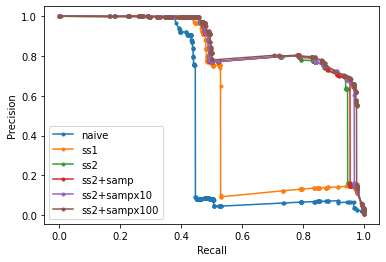

In [218]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall10, precision10, marker='.', label='ss2+samp')
pyplot.plot(recall11, precision11, marker='.', label='ss2+sampx10')
pyplot.plot(recall12, precision12, marker='.', label='ss2+sampx100')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [220]:
# setup as above
linker13 = DuckDBLinker([doc_site_sim1_a, doc_site_sim1_b], 
                     settings_dict=settings,
                     input_table_aliases=["a", "b"],
                     validate_settings=True,
                     #spark=spark, # you must include this so the linker object will initialize -- NOTES: cluster access mode must be singgle use -- not shared -- or this code will fail
                     #catalog='business_intelligence_and_practice_division_bipd_ppe',
                     #database='bipd_iae_modelling',
                     ) 
# Deterministic Rules are those that represent true matches 
deterministic_rules = [
    "l.firstname = r.firstname and l.lastname = r.lastname and r.pcode=l.pcode",
]

# suppress DepeciationWarnings 
with warnings.catch_warnings(): 
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    print("Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons")

    # push rules and plus a 'recall' rate i.e. recall is what proportion of true matches we think will be recovered from the deterministic rules
    linker13.estimate_probability_two_random_records_match(deterministic_rules, recall=0.38) ## 
###

## Once we have the probability_two_random_records_match parameter, we can estimate the u probabilities.
# estimate_u_using_random_sampling method doesn't require any labels.
# It works by sampling random pairs of records, since most of these pairs are going to be non-matches. Over these non-matches we compute the distribution of ComparisonLevels for each Comparison.
# For instance, for gender, we would find that the the gender matches 50% of the time, and mismatches 50% of the time.

for i in range(1):

    with warnings.catch_warnings():
        
        warnings.filterwarnings("ignore", category=DeprecationWarning)

        linker13.estimate_u_using_random_sampling(max_pairs=1e7) # larger the sample the better 


Direct estimation of the proportion matches, (probability two random records match) counts the number of matches from created from deterministic rules and compares them to total comparisons


Probability two random records match is estimated to be  0.000135.
This means that amongst all possible pairwise record comparisons, one in 7,428.06 are expected to match.  With 56,160,036 total possible comparisons, we expect a total of around 7,560.53 matching pairs
----- Estimating u probabilities using random sampling -----


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - firstname (no m values are trained).
    - lastname (no m values are trained).
    - pcode (no m values are trained).
    - phonenum (no m values are trained).


In [221]:
ss_table_1000 = ss_table.assign(semi_supervised_omega=1000)

In [222]:
# estimate with a semi-supervised rule
for i in range(len(blocking_rules)):

    rule_num = i + 1 
    print("\n", f"{rule_num} estimation pass....")
    linker13.estimate_parameters_using_expectation_maximisation(blocking_rules[i],semi_supervised_rules=[ {"sql": "gamma_firstname=0 AND gamma_lastname=0",
                                                                                   "match_probability": 0.0,
                                                                                   "omega":1},
                                                                                             {"sql": """(gamma_firstname=6 or gamma_firstname=4) AND 
                                                                                                        (gamma_lastname=4 or gamma_lastname=3) """,
                                                                                   "match_probability": 1.0,
                                                                                   "omega":1}          
                                                                                                       
                                                                                                       ],
                                                                        semi_supervised_table=ss_table_1000,
                                                                       comparisons_to_deactivate=[]
                                                                  )
    


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.firstname = r.firstname

Parameter estimates will be made for the following comparison(s):
    - lastname
    - pcode
    - phonenum

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 
    - firstname



 1 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r THEN 4 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.9 THEN 3 WHEN jaro_winkler_similarity(lastname_l, lastname_r) >= 0.8 THEN 2 WHEN damerau_levenshtein(lastname_l, lastname_r) = 2 THEN 1 ELSE 0 END as gamma_lastname,"pcode_

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level first initial match on comparison firstname not observed in dataset, unable to train m value

Level first initial match on comparison firstname not observed in dataset, unable to train u value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.80 - name spelling discrepancies on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 1 - one typos on comparison firstname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 - two typos on 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b4576e03a0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b45785c580>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4523c4370>]

 2 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshte

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train m value

Level Jaro_winkler >= 0.9 - front of string discrepdendies on comparison lastname not observed in dataset, unable to train u value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train m value

Level jaro_winkler >= 0.8 - name spelling discrepancies throughout str on comparison lastname not observed in dataset, unable to train u value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train m value

Level Damerau_levenshtein = 2 for typos on comparison lastname not observed in dataset, unable to train u value

Level All other comparisons on comparison lastname not observed in dataset, unable to train m value

Level All other comparisons on comparison lastname not observed in dataset, unable to train u value

Iteration 1: Larges

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b61df95310>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b4576ef7c0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b61dfa0d00>]

 3 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELS

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.698 in the u_probability of firstname, level `All other comparisons`
Iteration 2: Largest change in params was -0.0174 in the m_probability of lastname, level `All other comparisons`
Iteration 3: Largest change in params was -0.00509 in the m_probability of lastname, level `All other comparisons`
Iteration 4: Largest change in params was -0.00152 in the m_probability of lastname, level `All other comparisons`
Iteration 5: Largest change in params was -0.000477 in the m_probability of lastname, level `All other comparisons`
Iteration 6: Largest change in params was -0.000155 in the m_probability of lastname, level `All other comparisons`
Iteration 7: Largest change in params was -5.13e-05 in the m_probability of lastname, level `All other comparisons`

EM converged after 7 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values

----- Starting EM training session -----

Estimating the m pr

Adding estimates for comparisons to model:
[<Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b65bea1850>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b65bea1430>]

 4 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firstname_r) <= 1 THEN 2 WHEN damerau_levenshtein(firstname_l, firstname_r) = 2 THEN 1 ELSE 0 END as gamma_firstname,"lastname_l","lastname_r",CASE WHEN lastname_l IS NULL OR lastname_r IS NULL THEN -1 WHEN lastname_l = lastname_r

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.682 in the m_probability of pcode, level `All other comparisons`
Iteration 2: Largest change in params was 0.0365 in the m_probability of lastname, level `All other comparisons`
Iteration 3: Largest change in params was 0.00638 in the m_probability of lastname, level `All other comparisons`
Iteration 4: Largest change in params was 0.00145 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was 0.000355 in the m_probability of phonenum, level `All other comparisons`
Iteration 6: Largest change in params was 8.39e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 6 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values

----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
substr(l.phonenum,1,2)=substr(r.phonenum,1,2)

Parameter estimates will be made for 

Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b65be96910>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b6c8fbbfd0>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b65be755e0>]

 5 estimation pass....

    select "source_dataset_l","source_dataset_r","unique_id_l","unique_id_r","firstname_l","firstname_r",CASE WHEN firstname_l IS NULL OR firstname_r IS NULL THEN -1 WHEN firstname_l = firstname_r THEN 6 WHEN (length(firstname_l) = 1 OR length(firstname_r) = 1 ) AND (substr(firstname_l, 1, 1) = substr(firstname_r, 1, 1)) THEN 5 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.9 THEN 4 WHEN jaro_winkler_similarity(firstname_l, firstname_r) >= 0.80 THEN 3 WHEN damerau_levenshtein(firstname_l, firs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Index(['source_dataset_l', 'source_dataset_r', 'unique_id_l', 'unique_id_r',
       'firstname_l', 'firstname_r', 'gamma_firstname', 'lastname_l',
       'lastname_r', 'gamma_lastname', 'pcode_l', 'pcode_r', 'gamma_pcode',
       'phonenum_l', 'phonenum_r', 'gamma_phonenum', 'match_key'],
      dtype='object')



Iteration 1: Largest change in params was -0.795 in the m_probability of phonenum, level `All other comparisons`
Iteration 2: Largest change in params was -0.0241 in the m_probability of pcode, level `All other comparisons`
Iteration 3: Largest change in params was -0.0035 in the m_probability of phonenum, level `All other comparisons`
Iteration 4: Largest change in params was -0.00051 in the m_probability of phonenum, level `All other comparisons`
Iteration 5: Largest change in params was -7.37e-05 in the m_probability of phonenum, level `All other comparisons`

EM converged after 5 iterations

Your model is fully trained. All comparisons have at least one estimate for their m and u values


Adding estimates for comparisons to model:
[<Comparison Null vs Exact match vs. First Initial vs. jaro-w >= 0.9 vs. jaro_sim >= 0.80 vs. anything else with 7 levels at 0x2b6c8fb0640>, <Comparison Null vs Exact match vs. jaro-w >= 0.9 vs. jaro_winkler >= 0.77 vs.  damerau_levenshtein = 1 vs. damerau_levenshtein = 2 vs. anything else with 5 levels at 0x2b457732640>, <Comparison Null vs. exact vs D-L 1 vs D-L 2  vs. anything else with 4 levels at 0x2b457732910>]


In [223]:
predictions13_df = linker13.predict().as_pandas_dataframe()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [224]:
predictions_df = predictions_df.merge( predictions13_df[["unique_id_l","unique_id_r","match_weight","match_probability"]].rename(
                                                columns={"match_weight":"match_weight13",
                                                         "match_probability":"match_probability13"}),
                                      on = ["unique_id_l","unique_id_r"],
                                      how="outer"
                                        )


In [225]:
del predictions13_df

In [226]:

precision13, recall13, _ = precision_recall_curve(predictions_df["true_match"], predictions_df["match_probability13"])
auc(recall13, precision13)

0.9142189311875313

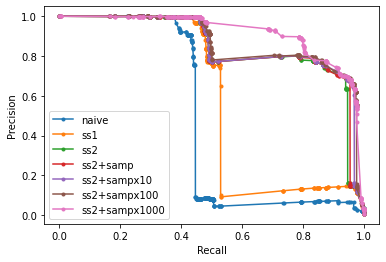

In [227]:
from matplotlib import pyplot
pyplot.plot(recall, precision, marker='.', label='naive')
pyplot.plot(recall2, precision2, marker='.', label='ss1')
pyplot.plot(recall3, precision3, marker='.', label='ss2')
pyplot.plot(recall10, precision10, marker='.', label='ss2+samp')
pyplot.plot(recall11, precision11, marker='.', label='ss2+sampx10')
pyplot.plot(recall12, precision12, marker='.', label='ss2+sampx100')
pyplot.plot(recall13, precision13, marker='.', label='ss2+sampx1000')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [230]:
linker11.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [229]:
linker12.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [228]:
linker13.m_u_parameters_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [231]:
linker13.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting


In [232]:
linker3.match_weights_chart()

<VegaLite 5 object>

If you see this message, it means the renderer has not been properly enabled
for the frontend that you are using. For more information, see
https://altair-viz.github.io/user_guide/display_frontends.html#troubleshooting
